In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
import requests
from bs4 import BeautifulSoup
import lxml
from urllib.parse import quote

from futsim_funcs import TPR,TFR,TPSR,TGKR,TDR

In [69]:
import warnings
warnings.filterwarnings("ignore", message="The default value of numeric_only in DataFrame.mean is deprecated.", category=FutureWarning)

In [70]:
players_df = pd.read_csv("../fifa24_db/pdb_23.csv")

In [71]:
tpr_data = TPR(players_df) # Overall
tfr_data = TFR(players_df) # Shooting
tgkr_data = TGKR(players_df) # Goalkeeping
tdr_data = TDR(players_df) # Defense

In [72]:
tdr_data.sort_values("power", ascending=False).head()

,league_id,club_team_id,league_name,club_name,power,defense
84,13,10,Premier League,Manchester City,85,74
109,53,243,La Liga,Real Madrid,84,78
30,13,5,Premier League,Chelsea,84,75
81,13,9,Premier League,Liverpool,84,75
70,31,44,Serie A,Inter,83,75


<br><br><br><br>

# FBRef Match Logs URLs

In [73]:
leagues = ["Premier League", "Serie A", "Ligue 1", "LaLiga", "Bundesliga"]
fbref_league_dict = {
    "Premier League": {"name": "Premier League", "league_id": 9},
    "Serie A": {"name": "Serie A", "league_id": 11},
    "Ligue 1": {"name": "Ligue 1", "league_id": 13},
    "LaLiga": {"name": "LaLiga", "league_id": 12},
    "Bundesliga": {"name": "Bundesliga", "league_id": 20},   
}

In [74]:
def GetTeamCredentials(league_id, season="2022-2023"):
    league_url = f"https://fbref.com/en/comps/{league_id}/{season}"
    response = requests.get(league_url)
    soup = BeautifulSoup(response.content, "lxml")

    table = soup.find("table", {"class": "stats_table"})
    team_ids = []
    team_names = []

    for row in table.find_all("tr")[1:]:
        team_name = row.find("td", {"data-stat": "team"}).text
        team_id = row.find("td", {"data-stat": "team"}).a.get("href").split("/")[3]
        team_ids.append(team_id)
        team_names.append(team_name)
    return {
        "team_ids":team_ids,
        "team_names":team_names,
    }

In [75]:
from rapidfuzz import process
def find_best_match(name, choices):
    return process.extractOne(name, choices)

In [76]:
def TFRFromId(tfr_data, club_team_id):
    power = tfr_data.query(f"club_team_id == {club_team_id}")["power"].iloc[0]
    finishing = tfr_data.query(f"club_team_id == {club_team_id}")["finishing"].iloc[0]
    return {
        "power": power,
        "finishing": finishing,
    }

In [77]:
def TeamNameIdConverter(tpr_data, team_name, league_id, print_output=False):
    # TeamNameIdConverter(tpr_data,"chelseas",13,1)
    club_team_names = tpr_data.query(f"league_id == {league_id}")["club_name"].tolist()
    club_team_ids = tpr_data.query(f"league_id == {league_id}")["club_team_id"].tolist()
    club_team_name, score, other = find_best_match(team_name, club_team_names)
    club_team_id = club_team_ids[club_team_names.index(club_team_name)]
    if print_output:
        print(f"ID for {club_team_name}:")
    return club_team_id

In [78]:
creds = GetTeamCredentials(fbref_league_dict["LaLiga"]["league_id"], "2022-2023")

def FB_URLS(stat_attribute, fbref_league_id, league_id, season="2022-2023"):
    team_ids = creds["team_ids"]
    team_names = creds["team_names"]
    club_team_names = tpr_data.query(f"league_id == {league_id}")["club_name"].tolist()
    club_team_ids = tpr_data.query(f"league_id == {league_id}")["club_team_id"].tolist()

    for team_id, team_name in zip(team_ids, team_names):
        best_match = find_best_match(team_name, club_team_names)
        if best_match:
            club_team_name, score, other = best_match
            club_team_id = club_team_ids[club_team_names.index(club_team_name)]
            match_logs_url = f"https://fbref.com/en/squads/{team_id}/{season}/matchlogs/c{fbref_league_id}/{stat_attribute}/{team_name.replace(' ', '-')}"
            match_logs_stats_dict[stat_attribute].append({
                "id": team_id,
                "stat": stat_attribute,
                "team": team_name,
                "club_team_id": club_team_id,
                "club_team_name": club_team_name, 
                "url": match_logs_url
            })
        else:
            print(f"No match found for team: {team_name}")

In [79]:
match_logs_stats_dict = {
    "shooting":[],
    "passing":[],
    "defense":[],
    "keeper":[],
    "passing_types":[],
    "gca":[],
    "possession":[],
    "misc":[],
}

attributes = match_logs_stats_dict.keys()
fbref_league_id = 12
league_id = 53

for stat_attribute in attributes:
    FB_URLS(stat_attribute, fbref_league_id, league_id)

In [80]:
### <Match Logs' URLS are Ready!>

<br><br><br><br>

<h1 style="color:green">Scraping FBRef</h1>

In [81]:
df=pd.read_html("https://fbref.com/en/squads/b8fd03ef/2022-2023/matchlogs/c9/shooting/-Manchester-City")[1][:38]
df.head(n=38).sort_values(('Against Manchester City', 'Date')).head()

Against Manchester City                                              \
                     Date   Time        Round  Day Venue Result GF GA   
0              2022-08-07  16:30  Matchweek 1  Sun  Home      L  0  2   
1              2022-08-13  15:00  Matchweek 2  Sat  Away      L  0  4   
2              2022-08-21  16:30  Matchweek 3  Sun  Home      D  3  3   
3              2022-08-27  15:00  Matchweek 4  Sat  Away      L  2  4   
4              2022-08-31  19:30  Matchweek 5  Wed  Away      L  0  6   

                   Standard  ...                   Expected                    \
          Opponent      Gls  ...  Dist FK PK PKatt       xG npxG npxG/Sh G-xG   
0         West Ham        0  ...  16.3  0  0     0      0.5  0.5    0.08 -0.5   
1      Bournemouth        0  ...  20.6  0  0     0      0.1  0.1    0.04 -0.1   
2    Newcastle Utd        3  ...  14.8  1  0     0      1.8  1.8    0.15  1.2   
3   Crystal Palace        1  ...  20.6  0  0     0      0.1  0.1    0.06  0.9   
4  Nott'ham Forest        0  ...  18.4  1  0     0      0.7  0.7    0.08 -0.7   

          Unnamed: 24_level_0  
  np:G-xG        Match Report  
0    -0.5        Match Report  
1    -0.1        Match Report  
2     1.2        Match Report  
3     0.9        Match Report  
4    -0.7        Match Report  

[5 rows x 25 columns]

In [82]:
def FB_MatchLogs(url, last_matchweek=38):
    encoded_url = quote(url, safe=':/')
    df=pd.read_html(encoded_url)
    return {
        "for": df[0][:last_matchweek],
        "against": df[1][:last_matchweek],
    }

In [83]:
def MatchLogs_MultiIndexColumnDict(df, stat_attribute=None):
    stat_columns_dict = {}
    for item in df.columns:
        right_side = item[1]
        stat_columns_dict[right_side] = item
    if stat_attribute:
        return stat_columns_dict[stat_attribute]
    return stat_columns_dict

In [84]:
match_logs_stats_dict["shooting"][0]

{'id': '206d90db',
 'stat': 'shooting',
 'team': ' Barcelona',
 'club_team_id': 241,
 'club_team_name': 'FC Barcelona',
 'url': 'https://fbref.com/en/squads/206d90db/2022-2023/matchlogs/c12/shooting/-Barcelona'}

<br><br><br><br>
<h1 style="color:black">Match Logs DataFrame</h1>

In [85]:
df_log_array = []

In [86]:
# for tindex in range(20):
#     print(tindex)
#     time.sleep(5)
#     current_team = match_logs_stats_dict["shooting"][tindex]

#     url = current_team["url"]
#     print(url)

    
#     df = FB_MatchLogs(url, last_matchweek=38)
#     df_for = df["for"]
#     df_against = df["against"]
#     logs_cols_for = MatchLogs_MultiIndexColumnDict(df_for)
#     logs_cols_against = MatchLogs_MultiIndexColumnDict(df_against)

#     team_names = df_for[logs_cols_for["Opponent"]].unique().tolist()
#     team_ids = [TeamNameIdConverter(tpr_data, team_name, 13) for team_name in team_names]
#     team_rating_data = TFRFromId(tfr_data, current_team["club_team_id"])

#     for i in range(38):
#         x = df_for.iloc[i]
#         y = df_against.iloc[i]
#         x_rating_data = TFRFromId(tfr_data, current_team["club_team_id"])
#         y_rating_data = TFRFromId(tfr_data, TeamNameIdConverter(tpr_data, y[logs_cols_against["Opponent"]], 13))
#         lab_df_dict = {
#             "team_name": current_team["club_team_name"],
#             "team_id": current_team["club_team_id"],
#             "team_sh": x[logs_cols_for["Sh"]],
#             "team_sot": x[logs_cols_for["SoT"]],
#             "team_scored": x[logs_cols_for["Gls"]],
#             "opponent_name": y[logs_cols_against["Opponent"]],
#             "opponent_id": TeamNameIdConverter(tpr_data, y[logs_cols_against["Opponent"]], 13),
#             "opponent_sh": y[logs_cols_against["Sh"]],
#             "opponent_sot": y[logs_cols_against["SoT"]],
#             "opponent_scored": y[logs_cols_against["Gls"]],
#             "team_power": x_rating_data["power"],
#             "team_finishing": x_rating_data["finishing"],
#             "opponent_power": y_rating_data["power"],
#             "opponent_finishing": y_rating_data["finishing"],
#             "team_sh_share": x[logs_cols_for["Sh"]] / ( x[logs_cols_for["Sh"]] + y[logs_cols_against["Sh"]] ),
#             "opponent_sh_share": y[logs_cols_against["Sh"]] / ( x[logs_cols_for["Sh"]] + y[logs_cols_against["Sh"]] ),
#         }
#         df_log_array.append(lab_df_dict)
        
# df_log = pd.DataFrame(df_log_array)
# league_name_for_csv_file = "laliga"
# df_log.to_csv(f"../@blacksmith/match_logs/fbref_match_logs_{league_name_for_csv_file}.csv")

In [87]:
league_name_for_csv_file = "laliga"
df_log = pd.read_csv(f"../@blacksmith/match_logs/fbref_match_logs_{league_name_for_csv_file}.csv")

In [88]:
df_log.tail(n=1)

,Unnamed: 0,team_name,team_id,team_sh,team_sot,team_scored,opponent_name,opponent_id,opponent_sh,opponent_sot,opponent_scored,team_power,team_finishing,opponent_power,opponent_finishing,team_sh_share,opponent_sh_share
759,759,Elche,468,12,5,1,Cádiz,10,14,3,1,74,74,85,82,0.461538,0.538462


<br><br><br><br>
<h1 style="color:red">Total Shot Volume</h1>

In [89]:
columns_to_drop = ['team_name','team_id','opponent_name','opponent_id']
df = df_log
df["total_sh"] =  df["team_sh"] + df["opponent_sh"]

<br><br>

In [90]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

features = ['team_power', 'team_finishing', 'opponent_power', 'opponent_finishing', "team_sh", "opponent_sh"]
target_variable = 'total_sh'

X = df[features]
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.19, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
coefficients = dict(zip(features, model.coef_))
print("Coefficients:", coefficients)

Mean Squared Error: 5.71461720582173e-29
Coefficients: {'team_power': 6.754936608704557e-16, 'team_finishing': 6.20584812029791e-16, 'opponent_power': 7.87027433001387e-16, 'opponent_finishing': 4.1536744215228106e-16, 'team_sh': 1.0000000000000002, 'opponent_sh': 1.0000000000000009}


In [91]:
df['predicted'] = model.predict(df[features])
df['predicted'] = df['predicted'].apply(int)
df['error'] = df[target_variable] - df['predicted']
df['error'].apply(abs).mean()

0.6157894736842106

In [92]:
df[columns_to_drop+features+[target_variable,"predicted","error"]].sort_values("predicted", ascending=False).head()

,team_name,team_id,opponent_name,opponent_id,team_power,team_finishing,opponent_power,opponent_finishing,team_sh,opponent_sh,total_sh,predicted,error
66,Real Madrid,243,Cádiz,10,84,80,85,82,35,12,47,47,0
522,Cádiz,1968,Real Madrid,1,75,73,79,78,12,35,47,47,0
679,Real Valladolid,462,Sevilla,2,74,71,79,72,28,17,45,45,0
451,Sevilla,481,Valladolid,2,81,75,79,72,17,28,45,45,0
182,Villarreal,483,Espanyol,1,80,82,79,78,30,14,44,44,0


<br><br>

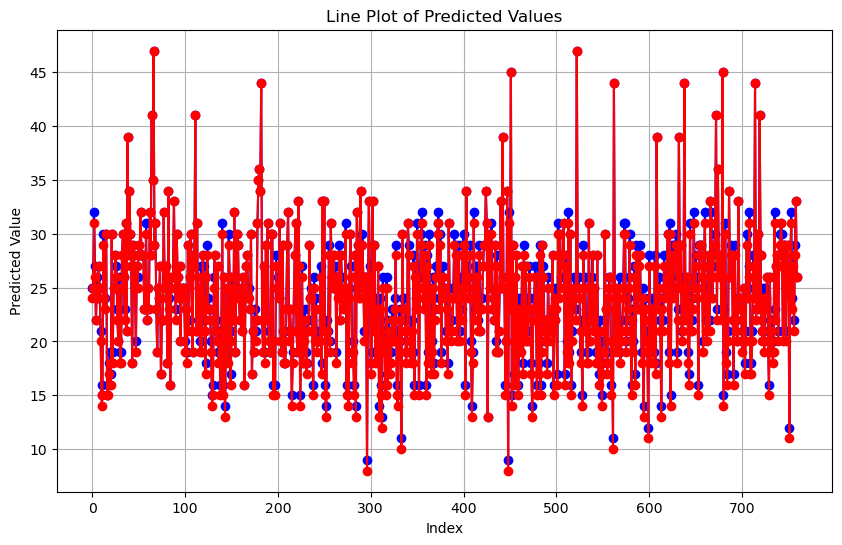

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df[target_variable], marker='o', linestyle='-', color="b")
plt.plot(df.index, df['predicted'], marker='o', linestyle='-', color="r")

plt.title('Line Plot of Predicted Values')
plt.xlabel('Index')
plt.ylabel('Predicted Value')
plt.grid(True)
plt.show()

Mean Squared Error: 5.71461720582173e-29
Coefficients: {'team_power': 6.754936608704557e-16, 'team_finishing': 6.20584812029791e-16, 'opponent_power': 7.87027433001387e-16, 'opponent_finishing': 4.1536744215228106e-16, 'team_sh': 1.0000000000000002, 'opponent_sh': 1.0000000000000009}


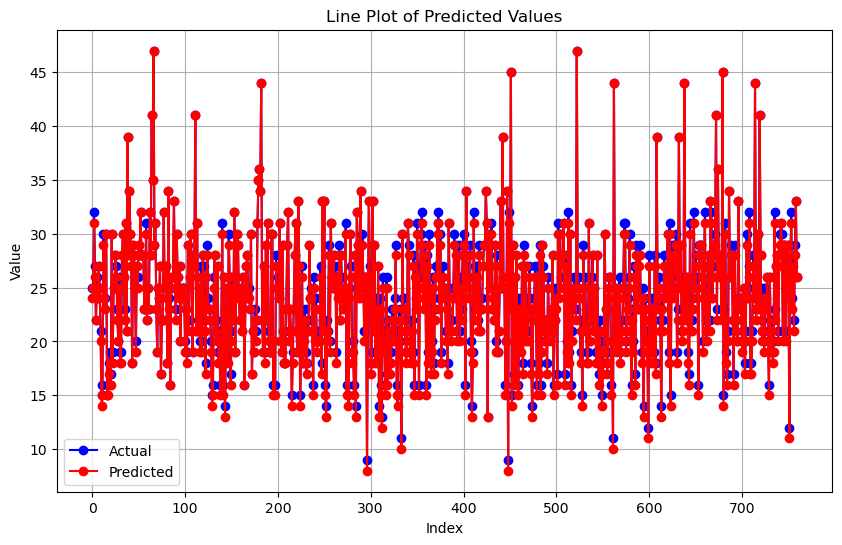

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def train_linear_regression(df, features, target_variable, test_size=0.19, random_state=42):
    """
    Train a linear regression model and evaluate its performance.

    Args:
    - df (DataFrame): Input DataFrame containing the dataset.
    - features (list): List of feature columns.
    - target_variable (str): Name of the target variable column.
    - test_size (float): Proportion of the dataset to include in the test split.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - model (LinearRegression): Trained linear regression model.
    - mse (float): Mean squared error of the model.
    - coefficients (dict): Coefficients of the trained model.
    """

    X = df[features]
    y = df[target_variable]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

    coefficients = dict(zip(features, model.coef_))
    print("Coefficients:", coefficients)

    return model, mse, coefficients

def plot_predicted_vs_actual(df, target_variable, model=None, features=None):
    """
    Plot the actual values and predicted values from a DataFrame.

    Args:
    - df (DataFrame): Input DataFrame containing the dataset.
    - target_variable (str): Name of the target variable column.
    - model (LinearRegression): Trained linear regression model.
    - features (list): List of feature columns used in the model (optional).

    Returns:
    - None
    """

    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[target_variable], marker='o', linestyle='-', color="b", label='Actual')
    
    if model and features:
        df['predicted'] = model.predict(df[features])
        df['predicted'] = df['predicted'].apply(int)
        plt.plot(df.index, df['predicted'], marker='o', linestyle='-', color="r", label='Predicted')
    
    plt.title('Line Plot of Predicted Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Train the model
features = ['team_power', 'team_finishing', 'opponent_power', 'opponent_finishing', "team_sh", "opponent_sh"]
target_variable = 'total_sh'
model, mse, coefficients = train_linear_regression(df, features, target_variable)

# Plot actual vs predicted
plot_predicted_vs_actual(df, target_variable, model=model, features=features)


<br><br><br><br>
<h1 style="color:red">Shot Share</h1>

In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

features = ['team_power', 'opponent_power', 'team_sh']
target_variable = 'team_sh_share'

X = df[features]
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.19, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
coefficients = dict(zip(features, model.coef_))
print("Coefficients:", coefficients)

Mean Squared Error: 0.010454492627425144
Coefficients: {'team_power': 0.00233564195515971, 'opponent_power': 0.0045686091577654565, 'team_sh': 0.026934208676092215}


In [96]:
df['predicted'] = model.predict(df[features])
df['error'] = df[target_variable] - df['predicted']
df['error'].apply(abs).mean()

0.07494883663644397

In [97]:
df[features+["team_sh_share","predicted","error"]]

,team_power,opponent_power,team_sh,team_sh_share,predicted,error
0,83,79,21,0.840000,0.747443,0.092557
1,83,79,15,0.600000,0.585838,0.014162
2,83,79,24,0.750000,0.828246,-0.078246
3,83,79,18,0.666667,0.666640,0.000026
4,83,85,16,0.727273,0.640184,0.087089
...,...,...,...,...,...,...
755,74,78,15,0.535714,0.560248,-0.024534
756,74,85,13,0.590909,0.538360,0.052549
757,74,79,20,0.689655,0.699488,-0.009833
758,74,83,6,0.181818,0.340684,-0.158865


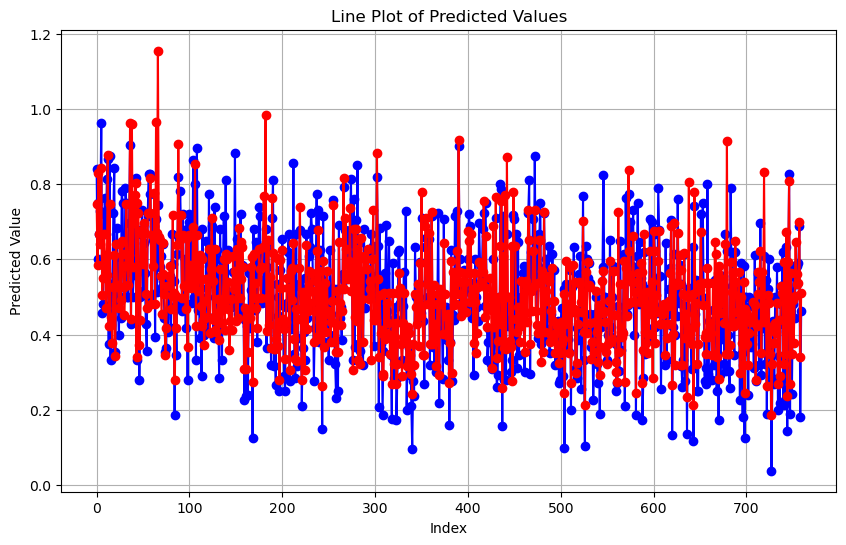

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df[target_variable], marker='o', linestyle='-', color="b")
plt.plot(df.index, df['predicted'], marker='o', linestyle='-', color="r")

plt.title('Line Plot of Predicted Values')
plt.xlabel('Index')
plt.ylabel('Predicted Value')
plt.grid(True)
plt.show()

<br><br><br><br>
<h1 style="color:red">Shot on Target</h1>

In [99]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

features = ['team_power', 'team_finishing', 'opponent_power', 'opponent_finishing', 'team_sh']
target_variable = 'team_sot'

X = df[features]
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.19, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
coefficients = dict(zip(features, model.coef_))
print("Coefficients:", coefficients)

Mean Squared Error: 3.0997762464964147
Coefficients: {'team_power': -0.006781383040600028, 'team_finishing': 0.024049662462010006, 'opponent_power': 0.012660476497835369, 'opponent_finishing': 0.006183903168975486, 'team_sh': 0.3078260986884965}


In [100]:
df['predicted'] = model.predict(df[features])
df['predicted'] = df['predicted'].apply(int)

df['error'] = df[target_variable] - df['predicted']
df['error'].apply(abs).mean()

1.3842105263157896

In [101]:
df[features+["team_sot","predicted","error"]].query("team_power == 84").sort_values("opponent_power", ascending=False).head(n=5)

,team_power,team_finishing,opponent_power,opponent_finishing,team_sh,team_sot,predicted,error
57,84,80,85,82,19,0,6,-6
51,84,80,85,82,18,5,6,-1
72,84,80,85,82,13,5,4,1
71,84,80,85,82,16,3,5,-2
42,84,80,85,82,22,7,7,0


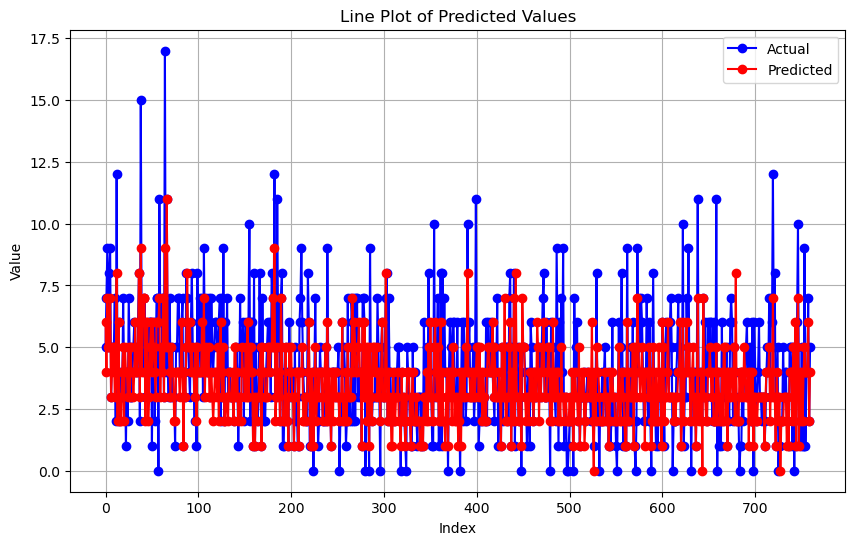

In [102]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df[target_variable], marker='o', linestyle='-', color="b", label='Actual')
plt.plot(df.index, df['predicted'], marker='o', linestyle='-', color="r", label='Predicted')
plt.title('Line Plot of Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [103]:
lineup_test_ids = [230621, 235212, 155862, 207865, 252145, 199556, 234153, 230767, 231747, 158023, 190871]
test_team_df = []
for player_id in lineup_test_ids:
    player_df = players_df[players_df['player_id'] == player_id]
    test_team_df.append(player_df)
result_df = pd.concat(test_team_df, ignore_index=True)
TFR(result_df)

,league_id,club_team_id,league_name,club_name,power,finishing
0,16,73,Ligue 1,Paris Saint Germain,85,79
